In [1]:
import os
import shutil
from tqdm import tqdm
from random import shuffle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from osgeo import gdal
from glob import glob

from keras import backend as K
import random
import albumentations as A
from sklearn.model_selection import train_test_split, StratifiedKFold

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.models import *
from tensorflow.keras.preprocessing.image import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.applications.efficientnet import *

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Load data

In [2]:
train = pd.read_csv('Train.csv')
test = pd.read_csv('Test.csv')
sub = pd.read_csv('SampleSubmission.csv')
print('train shape:', train.shape)
print('test shape:', test.shape)

train['path'] = train.Image_ID.apply(lambda x: 'Images/'+x+'.tif')
test['path'] = test.Image_ID.apply(lambda x: 'Images/'+x+'.tif')

train shape: (7000, 2)
test shape: (3000, 1)


In [3]:
train

,Image_ID,Target,path
0,ID_0073qfb8,0,Images/ID_0073qfb8.tif
1,ID_00gy3vH2,1,Images/ID_00gy3vH2.tif
2,ID_00uB3UFr,0,Images/ID_00uB3UFr.tif
3,ID_012xZpNw,1,Images/ID_012xZpNw.tif
4,ID_014GgMRb,1,Images/ID_014GgMRb.tif
...,...,...,...
6995,ID_zup5UL43,1,Images/ID_zup5UL43.tif
6996,ID_zvZNJeQB,0,Images/ID_zvZNJeQB.tif
6997,ID_zwGbT2eY,1,Images/ID_zwGbT2eY.tif
6998,ID_zxWcykW8,1,Images/ID_zxWcykW8.tif


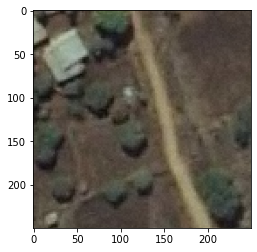

In [5]:
plt.imshow(np.transpose(gdal.Open(train[train.Target == 1].path.iloc[4]).ReadAsArray(), [1, 2, 0]))

In [351]:
def augment_image(image, input_shape):

    aug = A.Compose([
        
#         A.RandomSizedCrop(min_max_height=(int(0.9*input_shape[0]), int(0.9*input_shape[1])), 
#                           height=input_shape[0], width=input_shape[0], p=0.5),
        
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.Rotate(limit=[0, 90], p=0.5),
        
#         A.OneOf([
#             A.ElasticTransform(p=0.5, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
#             A.GridDistortion(p=0.5),
#             A.OpticalDistortion(distort_limit=0.5, shift_limit=0.5, p=1),
#         ], p=0.5),
        
        A.OneOf([
#             A.IAASharpen(),
#             A.IAAEmboss(),
            A.RandomBrightnessContrast(),
        ], p=0.5),
        
#         A.Blur(always_apply=False, p=0.5, blur_limit=(3, 10)),
        
#         A.Cutout(num_holes=20, max_h_size=10, max_w_size=10, fill_value=0, always_apply=False, p=0.5)
    
    ])

    augmented = aug(image=image)

    return augmented['image'] 

In [352]:
class CustomDataGen(tf.keras.utils.Sequence):
    
    def __init__(self, df,
                 augment=True,
                 batch_size=8,
                 input_shape=(224, 224, 3),
                 shuffle=True):
        
        self.paths = df.path.values
        self.labels = df.Target.values
        self.augment = augment
        self.batch_size = batch_size
        self.input_shape = input_shape
        self.shuffle = shuffle
        self.n = len(self.paths)
        self.on_epoch_end()
        
    
    def on_epoch_end(self):
        
        self.indexes = np.arange(len(self.paths))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    
    def __load_data(self, paths, labels):
    
        X_batch = []
        y_batch = []
        
        for path, label in zip(paths, labels):
            
            X = np.transpose(gdal.Open(path).ReadAsArray(), [1, 2, 0])
            if self.augment:
                X = augment_image(X, self.input_shape)
            X = cv2.resize(X, (self.input_shape[0], self.input_shape[1]))
            X_batch.append(X / 255.)
            
            y = np.zeros((2))
            y[label] = 1
            y_batch.append(y)
            
        return np.array(X_batch, dtype=float), np.array(y_batch, dtype=float)
    
    
    def __getitem__(self, index):
        
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        X, y = self.__load_data([self.paths[i] for i in indexes],
                                [self.labels[i] for i in indexes])        
        
        return X, y
    
    
    def __len__(self):
        
        return int(np.floor(len(self.paths) / self.batch_size))

/Users/neironeiro/miniforge3/lib/python3.9/site-packages/matplotlib/text.py:1215: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


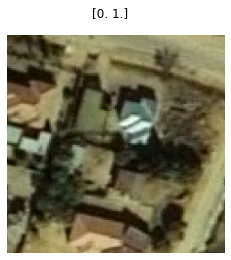

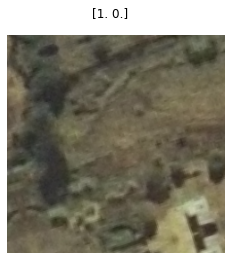

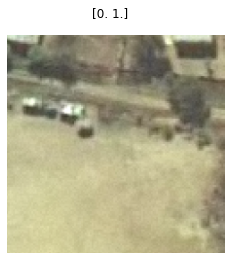

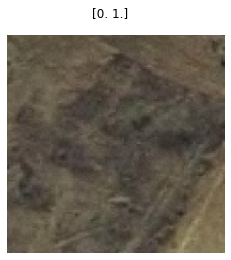

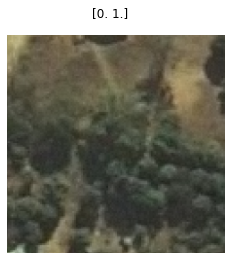

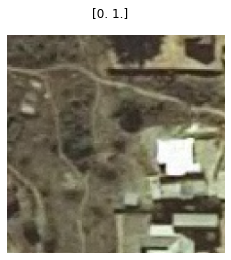

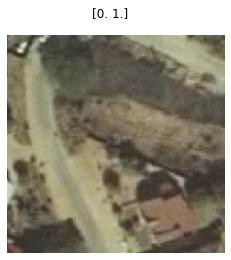

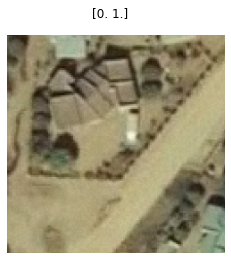

In [353]:
traingen = CustomDataGen(train, input_shape=(224, 224, 3))

for x, y in traingen:
    break

i = 0
for xx, yy in zip(x, y):
    plt.imshow(xx)
    plt.suptitle(yy)
    plt.axis('off')
    plt.savefig('{}.png'.format(i))
    plt.show()
    i+=1

## Training

In [89]:
def create_model(input_shape=(224, 224, 3)):
    
    inputs = Input(input_shape)
    base_model = EfficientNetB5(input_shape=input_shape, include_top=False, classes=2)
    
    x = base_model(inputs)
    
    x = GlobalAveragePooling2D()(x)
#     x = Dropout(0.1)(x)
    
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    
    outputs = Dense(2, activation='softmax')(x)
    
    model = Model(inputs, outputs)
    
    return model

In [90]:
K.clear_session()

model = create_model((64, 64, 3))
# model = load_model('models/checkpoint/EfficientNetB0.h5')

metrics = [
    'accuracy',
    'AUC'
]

model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=metrics)

In [91]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
efficientnetb5 (Functional)  (None, 2, 2, 2048)        28513527  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               524544    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 514       
Total params: 29,038,585
Trainable params: 28,865,842
Non-trainable params: 172,743
___________________________________________

In [94]:
train_df, val_df = train_test_split(train, test_size=0.15, stratify=train['Target'])

# train_indxs = []
# k = 0
# for _, train_index in StratifiedKFold(n_splits=4).split(train_df, train_df.Target):
#     train_index = list(train_index)
#     if k > 0:
#         train_index += train_indxs[k-1]
#     train_indxs.append(train_index)
#     k += 1

### EffB5 64

In [100]:
traingen_1 = CustomDataGen(train_df, input_shape=(64, 64, 3), batch_size=32)
valgen = CustomDataGen(val_df, input_shape=(64, 64, 3), batch_size=32, augment=False)

In [101]:
train_df.groupby('Target').path.count()

Target
0    2745
1    3205
Name: path, dtype: int64

In [102]:
checkpoint_path = 'models/EfficientNetB5/model_64.h5'
# checkpoint_dir = os.path.dirname(checkpoint_path)
# if os.path.exists(checkpoint_dir):
#         shutil.rmtree(checkpoint_dir)
# os.makedirs(checkpoint_dir)

callbacks = [
    EarlyStopping(monitor='val_loss', mode='min', patience=10, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', mode='min', factor=0.1, patience=5, min_lr=0.000001, verbose=1),
    ModelCheckpoint(monitor='val_loss', mode='min', filepath=checkpoint_path, verbose=1, save_best_only=True, save_weights_only=False)
]

In [103]:
results = model.fit(traingen_1, validation_data=valgen,
                    epochs=50,
                    callbacks=callbacks)

Epoch 1/50
185/185 [==============================] - 98s 529ms/step - loss: 0.3782 - accuracy: 0.8291 - auc: 0.9088 - val_loss: 0.3418 - val_accuracy: 0.8418 - val_auc: 0.9260

Epoch 00001: val_loss improved from inf to 0.34181, saving model to models/EfficientNetB5/model_64.h5
Epoch 2/50
185/185 [==============================] - 98s 529ms/step - loss: 0.3812 - accuracy: 0.8260 - auc: 0.9076 - val_loss: 0.3391 - val_accuracy: 0.8408 - val_auc: 0.9268

Epoch 00002: val_loss improved from 0.34181 to 0.33912, saving model to models/EfficientNetB5/model_64.h5
Epoch 3/50
185/185 [==============================] - 100s 538ms/step - loss: 0.3702 - accuracy: 0.8291 - auc: 0.9130 - val_loss: 0.3369 - val_accuracy: 0.8477 - val_auc: 0.9274

Epoch 00003: val_loss improved from 0.33912 to 0.33694, saving model to models/EfficientNetB5/model_64.h5
Epoch 4/50
185/185 [==============================] - 99s 537ms/step - loss: 0.3742 - accuracy: 0.8294 - auc: 0.9112 - val_loss: 0.3574 - val_accuracy:

### EffB5 128

In [134]:
train_df_2, val_df_2 = train_test_split(train, test_size=0.1, stratify=train['Target'])

traingen_2 = CustomDataGen(train_df_2, input_shape=(128, 128, 3), batch_size=16)
valgen = CustomDataGen(val_df_2, input_shape=(128, 128, 3), batch_size=16, augment=False)

In [131]:
K.clear_session()

model = create_model((128, 128, 3))

metrics = [
    'accuracy',
    'AUC'
]

model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=metrics)

In [132]:
checkpoint_path = 'models/EfficientNetB5/model_128.h5'
# checkpoint_dir = os.path.dirname(checkpoint_path)
# if os.path.exists(checkpoint_dir):
#         shutil.rmtree(checkpoint_dir)
# os.makedirs(checkpoint_dir)

callbacks = [
    EarlyStopping(monitor='val_loss', mode='min', patience=10, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', mode='min', factor=0.1, patience=5, min_lr=0.000001, verbose=1),
    ModelCheckpoint(monitor='val_loss', mode='min', filepath=checkpoint_path, verbose=1, save_best_only=True, save_weights_only=False)
]

In [135]:
results = model.fit(traingen_2, validation_data=valgen,
                    epochs=70,
                    callbacks=callbacks)

Epoch 1/70
393/393 [==============================] - 324s 820ms/step - loss: 0.4891 - accuracy: 0.7820 - auc: 0.8521 - val_loss: 0.6885 - val_accuracy: 0.5669 - val_auc: 0.5932

Epoch 00001: val_loss improved from inf to 0.68848, saving model to models/EfficientNetB5/model_128.h5


/Users/neironeiro/miniforge3/lib/python3.9/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/70
393/393 [==============================] - 317s 803ms/step - loss: 0.4168 - accuracy: 0.8104 - auc: 0.8915 - val_loss: 1.3638 - val_accuracy: 0.4622 - val_auc: 0.4499

Epoch 00002: val_loss did not improve from 0.68848
Epoch 3/70
393/393 [==============================] - 307s 781ms/step - loss: 0.3948 - accuracy: 0.8270 - auc: 0.9035 - val_loss: 1.7568 - val_accuracy: 0.5407 - val_auc: 0.5415

Epoch 00003: val_loss did not improve from 0.68848
Epoch 4/70
393/393 [==============================] - 1033s 3s/step - loss: 0.3756 - accuracy: 0.8360 - auc: 0.9118 - val_loss: 2.1334 - val_accuracy: 0.4578 - val_auc: 0.4578

Epoch 00004: val_loss did not improve from 0.68848
Epoch 5/70
393/393 [==============================] - 307s 780ms/step - loss: 0.3811 - accuracy: 0.8392 - auc: 0.9092 - val_loss: 2.3693 - val_accuracy: 0.4651 - val_auc: 0.4665

Epoch 00005: val_loss did not improve from 0.68848
Epoch 6/70
393/393 [==============================] - 306s 779ms/step - loss: 0.36

KeyboardInterrupt: 

### EffB0 224

In [96]:
from tensorflow.keras.applications import MobileNetV3Large

In [186]:
def create_model(input_shape=(224, 224, 3)):
    
    base_model = EfficientNetB0(input_shape=input_shape,
                                  include_top=False,
                                  weights='imagenet')

#     base_model = MobileNetV3Large(input_shape=input_shape,
#                                   include_top=False,
#                                   weights='imagenet')
    
#     base_model.trainable = False
    
    x = base_model.output
    
    x = GlobalAveragePooling2D()(x)
#     x = Dropout(0.1)(x)
    
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.1)(x)
    
    predictions = Dense(2, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=predictions)
    
    return model

In [187]:
K.clear_session()

model = create_model(input_shape=(224, 224, 3))

metrics = [
    'accuracy',
    'AUC'
]

model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=metrics)

In [188]:
train_df_3, val_df_3 = train_test_split(train, test_size=0.15, stratify=train['Target'])

traingen_3 = CustomDataGen(train_df_3, input_shape=(224, 224, 3), batch_size=16)
valgen_3 = CustomDataGen(val_df_3, input_shape=(224, 224, 3), batch_size=16, augment=False)

In [190]:
checkpoint_path = 'models/EfficientNetB0/model_224.h5'
# checkpoint_dir = os.path.dirname(checkpoint_path)
# if os.path.exists(checkpoint_dir):
#         shutil.rmtree(checkpoint_dir)
# os.makedirs(checkpoint_dir)

callbacks = [
    EarlyStopping(monitor='val_loss', mode='min', patience=10, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', mode='min', factor=0.1, patience=5, min_lr=0.000001, verbose=1),
    ModelCheckpoint(monitor='val_loss', mode='min', filepath=checkpoint_path, verbose=1, save_best_only=True, save_weights_only=False)
]

In [191]:
results = model.fit(traingen_3, validation_data=valgen_3,
                    epochs=50,
                    callbacks=callbacks)

Epoch 1/50
371/371 [==============================] - 90s 234ms/step - loss: 0.5792 - accuracy: 0.7015 - auc: 0.7732 - val_loss: 1.3405 - val_accuracy: 0.4615 - val_auc: 0.4863

Epoch 00001: val_loss improved from inf to 1.34046, saving model to models/EfficientNetB0/model_224.h5


/Users/neironeiro/miniforge3/lib/python3.9/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/50
371/371 [==============================] - 85s 230ms/step - loss: 0.5100 - accuracy: 0.7562 - auc: 0.8308 - val_loss: 1.0650 - val_accuracy: 0.5394 - val_auc: 0.5356

Epoch 00002: val_loss improved from 1.34046 to 1.06502, saving model to models/EfficientNetB0/model_224.h5
Epoch 3/50
371/371 [==============================] - 85s 230ms/step - loss: 0.4915 - accuracy: 0.7598 - auc: 0.8407 - val_loss: 0.7246 - val_accuracy: 0.3308 - val_auc: 0.2712

Epoch 00003: val_loss improved from 1.06502 to 0.72457, saving model to models/EfficientNetB0/model_224.h5
Epoch 4/50
371/371 [==============================] - 86s 231ms/step - loss: 0.4822 - accuracy: 0.7722 - auc: 0.8501 - val_loss: 0.7422 - val_accuracy: 0.4510 - val_auc: 0.4323

Epoch 00004: val_loss did not improve from 0.72457
Epoch 5/50
371/371 [==============================] - 86s 230ms/step - loss: 0.4809 - accuracy: 0.7732 - auc: 0.8515 - val_loss: 14.5669 - val_accuracy: 0.5413 - val_auc: 0.5413

Epoch 00005: val_loss 

KeyboardInterrupt: 

### EffB5 128 l2

In [347]:
def create_model(input_shape=(224, 224, 3)):
    
    inputs = Input(input_shape)
    base_model = EfficientNetB0(input_shape=input_shape, include_top=False, classes=2)
                
    x = base_model(inputs)
    
    x = GlobalAveragePooling2D()(x)
#     x = Dropout(0.1)(x)
    
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.01)(x)
    
    outputs = Dense(2, activation='softmax')(x)
    
    model = Model(inputs, outputs)
    
    return model

In [354]:
train_df, val_df = train_test_split(train, test_size=0.15, stratify=train['Target'], random_state=17)

traingen = CustomDataGen(train_df, input_shape=(128, 128, 3), batch_size=16)
valgen = CustomDataGen(val_df, input_shape=(128, 128, 3), batch_size=16, augment=True)

In [362]:
model = load_model('models/EfficientNetB5/model_128.h5')

regularizer = tf.keras.regularizers.l2(0.001)
for layer in model.layers:
    for attr in ['kernel_regularizer']:
        if hasattr(layer, attr):
            setattr(layer, attr, regularizer)
            
model.compile(optimizer=Adam(learning_rate=0.00001), loss='binary_crossentropy', metrics=metrics)

checkpoint_path = 'models/EfficientNetB0/model_128_l2.h5'

callbacks = [
    EarlyStopping(monitor='val_loss', mode='min', patience=10, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', mode='min', factor=0.1, patience=5, min_lr=0.000001, verbose=1),
    ModelCheckpoint(monitor='val_loss', mode='min', filepath=checkpoint_path, verbose=1, save_best_only=True, save_weights_only=False)
]

In [363]:
results = model.fit(traingen, validation_data=valgen,
                    epochs=70,
                    callbacks=callbacks)

Epoch 1/70
371/371 [==============================] - 311s 814ms/step - loss: 0.2653 - accuracy: 0.8898 - auc: 0.9546 - val_loss: 0.2454 - val_accuracy: 0.8904 - val_auc: 0.9625

Epoch 00001: val_loss improved from inf to 0.24545, saving model to models/EfficientNetB0/model_128_l2.h5


/Users/neironeiro/miniforge3/lib/python3.9/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/70
371/371 [==============================] - 298s 802ms/step - loss: 0.2619 - accuracy: 0.8888 - auc: 0.9558 - val_loss: 0.2438 - val_accuracy: 0.9019 - val_auc: 0.9619

Epoch 00002: val_loss improved from 0.24545 to 0.24378, saving model to models/EfficientNetB0/model_128_l2.h5
Epoch 3/70
371/371 [==============================] - 300s 809ms/step - loss: 0.2567 - accuracy: 0.8905 - auc: 0.9569 - val_loss: 0.2481 - val_accuracy: 0.8913 - val_auc: 0.9606

Epoch 00003: val_loss did not improve from 0.24378
Epoch 4/70
371/371 [==============================] - 302s 813ms/step - loss: 0.2574 - accuracy: 0.8900 - auc: 0.9570 - val_loss: 0.2588 - val_accuracy: 0.8904 - val_auc: 0.9552

Epoch 00004: val_loss did not improve from 0.24378
Epoch 5/70
371/371 [==============================] - 295s 794ms/step - loss: 0.2529 - accuracy: 0.8937 - auc: 0.9589 - val_loss: 0.2368 - val_accuracy: 0.9019 - val_auc: 0.9643

Epoch 00005: val_loss improved from 0.24378 to 0.23677, saving model to 

### EffB5 128 l2=0.01 another data

In [394]:
train_df, val_df = train_test_split(train, test_size=0.125, stratify=train['Target'], random_state=17)

traingen = CustomDataGen(train_df, input_shape=(128, 128, 3), batch_size=16)
valgen = CustomDataGen(val_df, input_shape=(128, 128, 3), batch_size=16, augment=True)

In [395]:
model = load_model('models/EfficientNetB0/model_128_l2.h5')

regularizer = tf.keras.regularizers.l2(0.01)
for layer in model.layers:
    for attr in ['kernel_regularizer']:
        if hasattr(layer, attr):
            setattr(layer, attr, regularizer)
            
model.compile(optimizer=Adam(learning_rate=0.00001), loss='binary_crossentropy', metrics=metrics)

checkpoint_path = 'models/EfficientNetB5/model_128_l2_2.h5'

callbacks = [
    EarlyStopping(monitor='val_loss', mode='min', patience=10, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', mode='min', factor=0.1, patience=5, min_lr=0.0000001, verbose=1),
    ModelCheckpoint(monitor='val_loss', mode='min', filepath=checkpoint_path, verbose=1, save_best_only=True, save_weights_only=False)
]

In [396]:
results = model.fit(traingen, validation_data=valgen,
                    epochs=70,
                    callbacks=callbacks)

Epoch 1/70
382/382 [==============================] - 331s 835ms/step - loss: 0.7653 - accuracy: 0.8919 - auc: 0.9571 - val_loss: 0.7154 - val_accuracy: 0.8866 - val_auc: 0.9593

Epoch 00001: val_loss improved from inf to 0.71540, saving model to models/EfficientNetB5/model_128_l2_2.h5


/Users/neironeiro/miniforge3/lib/python3.9/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/70
382/382 [==============================] - 316s 824ms/step - loss: 0.6875 - accuracy: 0.8922 - auc: 0.9566 - val_loss: 0.6694 - val_accuracy: 0.8900 - val_auc: 0.9513

Epoch 00002: val_loss improved from 0.71540 to 0.66944, saving model to models/EfficientNetB5/model_128_l2_2.h5
Epoch 3/70
382/382 [==============================] - 304s 793ms/step - loss: 0.6202 - accuracy: 0.8930 - auc: 0.9581 - val_loss: 0.5935 - val_accuracy: 0.8866 - val_auc: 0.9556

Epoch 00003: val_loss improved from 0.66944 to 0.59348, saving model to models/EfficientNetB5/model_128_l2_2.h5
Epoch 4/70
382/382 [==============================] - 301s 786ms/step - loss: 0.5618 - accuracy: 0.8956 - auc: 0.9586 - val_loss: 0.5581 - val_accuracy: 0.8681 - val_auc: 0.9512

Epoch 00004: val_loss improved from 0.59348 to 0.55808, saving model to models/EfficientNetB5/model_128_l2_2.h5
Epoch 5/70
382/382 [==============================] - 301s 785ms/step - loss: 0.5134 - accuracy: 0.8922 - auc: 0.9585 - val_los

KeyboardInterrupt: 

### Pseudo Labeling EffB5 128 

In [245]:
test_pseudo = test.copy()
test_pseudo['Target'] = pd.read_csv('subs/sub_3.csv')['Target']

test_pseudo = test_pseudo[(test_pseudo.Target > 0.9)|(test_pseudo.Target < 0.1)]

test_pseudo.loc[(test_pseudo.Target >= 0.5), 'Target'] = 1
test_pseudo.loc[(test_pseudo.Target < 0.5), 'Target'] = 0
test_pseudo['Target'] = test_pseudo['Target'].astype(int)

In [246]:
K.clear_session()

model = load_model('models/EfficientNetB5/model_128.h5')

metrics = [
    'accuracy',
    'AUC'
]

model.compile(optimizer=Adam(learning_rate=0.00001), loss='binary_crossentropy', metrics=metrics)

In [247]:
train_pseudo, val_pseudo = train_test_split(train, 
                                            test_size=0.25, 
                                            stratify=train['Target'])

train_pseudo = pd.concat([train_pseudo, test_pseudo], ignore_index=True)

traingen_pseudo = CustomDataGen(test_pseudo, input_shape=(128, 128, 3), batch_size=16)
valgen_pseudo = CustomDataGen(val_pseudo, input_shape=(128, 128, 3), batch_size=16, augment=False)

In [248]:
checkpoint_path = 'models/EfficientNetB5/model_128_pseudo.h5'
# checkpoint_dir = os.path.dirname(checkpoint_path)
# if os.path.exists(checkpoint_dir):
#         shutil.rmtree(checkpoint_dir)
# os.makedirs(checkpoint_dir)

callbacks = [
    EarlyStopping(monitor='val_loss', mode='min', patience=10, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', mode='min', factor=0.1, patience=5, min_lr=0.000001, verbose=1),
    ModelCheckpoint(monitor='val_loss', mode='min', filepath=checkpoint_path, verbose=1, save_best_only=True, save_weights_only=False)
]

In [249]:
results = model.fit(traingen_pseudo, 
                    validation_data=valgen_pseudo,
                    epochs=50,
                    callbacks=callbacks)

Epoch 1/50
142/142 [==============================] - 155s 1s/step - loss: 0.3250 - accuracy: 0.8693 - auc: 0.9317 - val_loss: 0.2364 - val_accuracy: 0.8968 - val_auc: 0.9642

Epoch 00001: val_loss improved from inf to 0.23644, saving model to models/EfficientNetB5/model_128_pseudo.h5


/Users/neironeiro/miniforge3/lib/python3.9/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/50
142/142 [==============================] - 146s 1s/step - loss: 0.2920 - accuracy: 0.8847 - auc: 0.9439 - val_loss: 0.2433 - val_accuracy: 0.9048 - val_auc: 0.9616

Epoch 00002: val_loss did not improve from 0.23644
Epoch 3/50
142/142 [==============================] - 145s 1s/step - loss: 0.2947 - accuracy: 0.8763 - auc: 0.9428 - val_loss: 0.2412 - val_accuracy: 0.8979 - val_auc: 0.9632

Epoch 00003: val_loss did not improve from 0.23644
Epoch 4/50
142/142 [==============================] - 146s 1s/step - loss: 0.2622 - accuracy: 0.8908 - auc: 0.9558 - val_loss: 0.2529 - val_accuracy: 0.8951 - val_auc: 0.9603

Epoch 00004: val_loss did not improve from 0.23644
Epoch 5/50
142/142 [==============================] - 145s 1s/step - loss: 0.2603 - accuracy: 0.8988 - auc: 0.9552 - val_loss: 0.2572 - val_accuracy: 0.8922 - val_auc: 0.9579

Epoch 00005: val_loss did not improve from 0.23644
Epoch 6/50
142/142 [==============================] - 146s 1s/step - loss: 0.2612 - accuracy

KeyboardInterrupt: 

# Testing

In [397]:
class TestDataGen(tf.keras.utils.Sequence):
    
    def __init__(self, df,
                 augment=True,
                 batch_size=8,
                 input_shape=(224, 224, 3),
                 shuffle=True):
        
        self.paths = df.path.values
        self.augment = augment
        self.batch_size = batch_size
        self.input_shape = input_shape
        self.shuffle = shuffle
        self.n = len(self.paths)
        self.indexes = np.arange(len(self.paths))
        
    
    def __load_data(self, paths):
    
        X_batch = []
        
        for path in paths:
            
            X = np.transpose(gdal.Open(path).ReadAsArray(), [1, 2, 0])
            if self.augment:
                X = augment_image(X, self.input_shape)
            X = cv2.resize(X, (self.input_shape[0], self.input_shape[1]))
            X_batch.append(X / 255.)
            
        return np.array(X_batch, dtype=float)
    
    
    def __getitem__(self, index):
        
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        X = self.__load_data([self.paths[i] for i in indexes])        
        
        return X
    
    
    def __len__(self):
        
        return int(np.floor(len(self.paths) / self.batch_size))

In [398]:
# model = load_model('models/EfficientNetB0/model_128_l2.h5')

model = load_model('models/EfficientNetB5/model_128_l2_2.h5')

In [399]:
testgen = TestDataGen(test, input_shape=(128, 128, 3), augment=False)
preds = model.predict(testgen)[:, 1]

testgen = TestDataGen(test, input_shape=(128, 128, 3), augment=True)
for i in tqdm(range(10)):
    preds = np.vstack([preds, model.predict(testgen)[:, 1]])

100%|██████████| 10/10 [05:49<00:00, 34.91s/it]


In [400]:
preds[:, 0]

array([1.2809798e-02, 5.4660439e-03, 9.4463502e-04, 5.1202864e-04,
       1.6653076e-02, 9.2327587e-05, 1.1867010e-03, 1.2864194e-02,
       5.0382427e-04, 1.1788551e-03, 1.5822385e-02], dtype=float32)

In [401]:
preds.shape

(11, 3000)

In [402]:
# sub['Target'] = np.mean(preds, axis=0)

In [425]:
sub['Target'] = np.median(preds, axis=0)

In [404]:
# sub['Target'] = preds

In [426]:
sub

,Image_ID,Target
0,ID_01c6i2wd,0.001187
1,ID_03sPqBLY,0.004773
2,ID_06ZKUQFl,0.999999
3,ID_06gzqIwK,0.000117
4,ID_08kWat36,0.017619
...,...,...
2995,ID_zxBFKP2n,0.000060
2996,ID_zxN7nQbW,0.061935
2997,ID_zyWc0ENM,0.561806
2998,ID_zywRGuyq,0.038649


In [55]:
sub

,Image_ID,Target
0,ID_01c6i2wd,0.009792
1,ID_03sPqBLY,0.005597
2,ID_06ZKUQFl,0.999999
3,ID_06gzqIwK,0.000006
4,ID_08kWat36,0.008275
...,...,...
2995,ID_zxBFKP2n,0.000085
2996,ID_zxN7nQbW,0.086370
2997,ID_zyWc0ENM,0.361170
2998,ID_zywRGuyq,0.017085


In [427]:
sub.to_csv('subs/sub_19.csv', index=False)

In [428]:
temp = pd.DataFrame()
temp[1] = pd.read_csv('subs/sub_11.csv')['Target']
temp[2] = pd.read_csv('subs/sub_13.csv')['Target']
temp[3] = pd.read_csv('subs/sub_19.csv')['Target']

In [429]:
sub['Target'] = 0.5*temp[1] + 0.25*temp[2] + 0.25*temp[3]

In [430]:
# sub.Target = sub.Target.clip(0.001, 0.999)

In [431]:
sub.to_csv('subs/sub_20.csv', index=False)

In [390]:
sub3 = pd.read_csv('subs/sub_11.csv').copy()

In [391]:
sub3['Target'] = np.round(sub3.Target ** 2, 6)

In [393]:
sub3.to_csv('subs/sub_12.csv', index=False)

In [392]:
sub3

,Image_ID,Target
0,ID_01c6i2wd,0.000104
1,ID_03sPqBLY,0.000250
2,ID_06ZKUQFl,0.999968
3,ID_06gzqIwK,0.000000
4,ID_08kWat36,0.000274
...,...,...
2995,ID_zxBFKP2n,0.000000
2996,ID_zxN7nQbW,0.049011
2997,ID_zyWc0ENM,0.230065
2998,ID_zywRGuyq,0.000653


In [324]:
from sklearn.metrics import *

In [ ]:
auc()